In [13]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

In [15]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)  
old_shape = train_X.shape
print("old shape ", old_shape)
old_test_X = test_X.copy()  
train_X, test_X = prepare_for_neural_network(train_X, test_X)

# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

old shape  (10000, 32, 32, 3)


Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:

прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам
Начнем с ReLU, у которого параметров нет.

In [16]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3], [-1, 2, 0.1]])

assert check_layer_gradient(ReLULayer(), X)

CHECK GRADIENT
x is 
 [[ 1.  -2.   3. ]
 [-1.   2.   0.1]]
analytic grad is 
 [[ 1.61599406  0.          2.76252524]
 [-0.         -0.5060347  -0.94302519]]
numeric grad array is 
 [[ 1.61599406  0.          2.76252524]
 [ 0.         -0.5060347  -0.94302519]]
Gradient check passed!


In [20]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

CHECK GRADIENT
x is 
 [[ 1.  -2.   3. ]
 [-1.   2.   0.1]]
analytic grad is 
 [[ 0.00011948  0.00181837  0.00091042]
 [ 0.00025099 -0.0002961  -0.00126098]]
numeric grad array is 
 [[ 2.98704951e-05  4.54591519e-04  2.27606249e-04]
 [ 6.27472131e-05 -7.40255001e-05 -3.15244788e-04]]
Gradients are different at (0, 0). Analytic: 0.00012, Numeric: 0.00003


AssertionError: 

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
batch_size = 2
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:batch_size], train_y[:batch_size])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:batch_size], train_y[:batch_size])

Checking gradient for W1
CHECK GRADIENT
x is 
 [[ 5.55132245e-04 -8.29725676e-04 -9.95647818e-04]
 [ 7.71607110e-04  8.55758768e-04 -1.27373828e-03]
 [-1.23679768e-03 -4.45049694e-04 -7.11304833e-04]
 ...
 [-1.27559794e-03 -5.69992050e-04  4.02575187e-04]
 [ 2.28669670e-04  1.30825243e-03  7.03814008e-06]
 [-1.76402810e-04 -1.57398266e-03 -8.06722910e-04]]
analytic grad is 
 [[ 2.10787160e-05  0.00000000e+00 -4.47056165e-05]
 [ 2.51157965e-05  0.00000000e+00 -9.99876323e-06]
 [ 7.14281875e-05  0.00000000e+00  8.78028877e-05]
 ...
 [-1.96137432e-04  0.00000000e+00 -1.67966637e-04]
 [-1.75261159e-04  0.00000000e+00 -1.05706581e-04]
 [-1.39601392e-04  0.00000000e+00 -5.89752946e-06]]
numeric grad array is 
 [[ 2.10787388e-05  0.00000000e+00 -4.47056170e-05]
 [ 2.51157761e-05  0.00000000e+00 -9.99875738e-06]
 [ 7.14281967e-05  0.00000000e+00  8.78028317e-05]
 ...
 [-1.96137417e-04  0.00000000e+00 -1.67966618e-04]
 [-1.75261183e-04  0.00000000e+00 -1.05706555e-04]
 [-1.39601397e-04  0.00000

True

In [24]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W1
CHECK GRADIENT
x is 
 [[ 9.41373293e-04  5.33324902e-04  5.27535078e-04]
 [ 2.89300749e-05  1.20871730e-03 -1.32706239e-03]
 [-1.09817308e-03  1.09664790e-03 -2.82905448e-04]
 ...
 [ 1.96881473e-03  1.03123924e-03 -7.40687847e-04]
 [ 5.48426909e-05 -2.26804832e-04 -5.89332079e-04]
 [-9.09640639e-05 -1.32315561e-04  1.83669030e-03]]
analytic grad is 
 [[ 0.0186935   0.01064296  0.01057437]
 [ 0.00052534  0.02416908 -0.02651305]
 [-0.02182921  0.02197919 -0.00557791]
 ...
 [ 0.03918741  0.02053633 -0.01503398]
 [ 0.00103717 -0.00459176 -0.01198342]
 [-0.00167435 -0.00264942  0.03657706]]
numeric grad array is 
 [[ 0.0186935   0.01064296  0.01057437]
 [ 0.00052534  0.02416908 -0.02651305]
 [-0.02182921  0.02197919 -0.00557791]
 ...
 [ 0.03918741  0.02053633 -0.01503398]
 [ 0.00103717 -0.00459176 -0.01198342]
 [-0.00167435 -0.00264942  0.03657706]]
Gradient check passed!
Checking gradient for B1
CHECK GRADIENT
x is 
 [[0.00032891 0.0008259  0.0010484 ]]
analytic gr

True

In [25]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.16666666666666666

**Допишем код для процесса тренировки**


Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [38]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(),num_epochs =20, batch_size=20, learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

X shape is
 (9000, 3072)
y shape is
 (9000,)
Loss: 33.650671, Train accuracy: 0.385667, val accuracy: 0.412000
test accuracy is  38.56666666666666
Loss: 21.759588, Train accuracy: 0.533667, val accuracy: 0.528000
test accuracy is  53.36666666666666
Loss: 32.320432, Train accuracy: 0.654778, val accuracy: 0.642000
test accuracy is  65.47777777777777
Loss: 29.677727, Train accuracy: 0.667333, val accuracy: 0.615000
test accuracy is  66.73333333333333
Loss: 34.792962, Train accuracy: 0.693556, val accuracy: 0.670000
test accuracy is  69.35555555555555
Loss: 31.532961, Train accuracy: 0.624889, val accuracy: 0.591000
test accuracy is  62.488888888888894
Loss: 23.974836, Train accuracy: 0.705222, val accuracy: 0.662000
test accuracy is  70.52222222222223
Loss: 20.869080, Train accuracy: 0.727778, val accuracy: 0.678000
test accuracy is  72.77777777777777
Loss: 18.850755, Train accuracy: 0.714889, val accuracy: 0.657000
test accuracy is  71.4888888888889
Loss: 20.890261, Train accuracy: 0.76

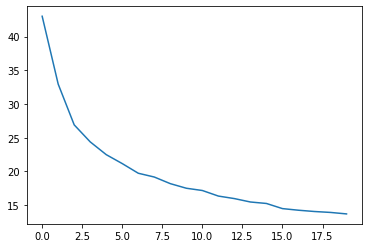

In [39]:
plt.plot(loss_history)
# plt.plot(train_history)
# plt.plot(val_history)

test x is  (1000, 3072)
test pred is 
 [2 1 8 1 2 5 0 1 7 1]
test_y  is 
 [2 1 3 0 2 5 0 1 7 1]


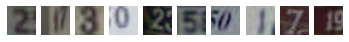

Neural network classifier test set accuracy: 69.800000


In [40]:
# model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)


number = 10
print("test x is ", test_X.shape)
test_pred = model.predict(test_X[:number])
print("test pred is \n", test_pred)
print("test_y  is \n", test_y[:number])
plot_index = 1
for class_index in range(number):
        plt.subplot(1, number, plot_index)
        
        image = old_test_X[class_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

plt.show()
# print("test pred is \n", test_pred[:number])

test_pred = model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)*100
print('Neural network classifier test set accuracy: %f' % (test_accuracy, ))

In [45]:
X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

Y = np.array([[1,3,3],
              [-1, 2, 0.1]
              ])
print(X*Y)

mapa = {'X': X, 'Y': Y}
mapa['X'] = np.zeros_like(X)

zer = np.ones((3,4))
loss = 3
reg_loss1 = 2
reg_loss2 = 7
loss += reg_loss1 + reg_loss2
# print("zer\n",zer)
print("loss is ", loss)
print("X is \n", X)

[[ 1.   -6.    9.  ]
 [ 1.    4.    0.01]]
loss is  12
X is 
 [[ 1.  -2.   3. ]
 [-1.   2.   0.1]]
